# 2$\nu_x - \nu_y$ Resonance

0. [Functions](#chapter0)
1. [Pulse/AC Skew Sextupole](#chapter1)\
    1.1 [Single Particle](#chapter1.1)\
    1.2 [Multiparticle](#chapter1.2)
2. [Resonance Crossing](#chapter2)\
    2.1 [Single Particle](#chapter2.1)\
    2.2 [Multiparticle](#chapter2.2)
3. [AC Skew Sextupole](#chapter3)\
    3.1 [Single Particle](#chapter3.1)\
    3.2 [Multiparticle](#chapter3.2)  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from IPython.display import display, Math

#Run all functions before running anything else

# 0. Functions <a name="chapter0"></a>

In [2]:
def epsilon_single(a, b, g, x, xp): return (g*x**2 + 2*a*x*xp + b*xp**2)/2

# http://cds.cern.ch/record/242313/files/p89.pdf
def epsilon_multi(X, Xp): 
    r = np.mean(X*Xp)/np.sqrt(np.mean(X**2)*np.mean(Xp**2))
    return 4*np.std(X)*np.std(Xp)*np.sqrt(1 - r**2)

def M_phase(Twiss):
    ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_x, nu_y = Twiss
    Sx, Sy = np.sin(2*np.pi*nu_x), np.sin(2*np.pi*nu_y)
    Cx, Cy = np.cos(2*np.pi*nu_x), np.cos(2*np.pi*nu_y)
    M = np.array([np.array([Cx + ax*Sx, bx*Sx, 0, 0]),
                 np.array([-gx*Sx, Cx - ax*Sx, 0, 0]),
                 np.array([0, 0, Cy + ay*Sy, by*Sy]),
                 np.array([0, 0, -gy*Sy, Cy - ay*Sy])])
    return M

In [3]:
# Visualize exchange
def Exchange_multi(X_hist, save_txt, ncol = 5, size = 1):
    nrow = 2

    N_turns = len(X_hist)
    N_part = len(X_hist[0])
    fig, Ax = plt.subplots(nrow, ncol, figsize = (25, 8))
    fig.suptitle('Phase Space For %d Particles'%N_part)
    xbound = []
    ybound = []
    factor = N_turns//(ncol - 1)
    for i in range(nrow):
        for j in range(ncol):
            index = factor*j
            if factor*j == N_turns:
                index = -1
            X_hist_sub = X_hist[index].T
            xbound.append(np.max(np.abs(X_hist_sub[i*2])))
            ybound.append(np.max(np.abs(X_hist_sub[i*2 + 1])))

    xbound_Max = np.max(xbound) + .001
    ybound_Max = np.max(ybound) + .0005

    for i in range(nrow):
        xlab = ""
        ylab = ""
        if i == 0:
            xlab = "x"
            Ax[i][0].set_ylabel(r"$x^'$")
            
        if i == 1:
            xlab = "y"
            Ax[i][0].set_ylabel(r"$y^'$")

        for j in range(ncol):
            index = factor*j
            if factor*j == N_turns:
                index = -1
            X_hist_sub = X_hist[index].T

            Ax[i][j].plot(X_hist_sub[i*2], X_hist_sub[i*2 + 1], "o", mfc = 'black', ms = size)
            Ax[i][j].set_xlabel(xlab)

            Ax[i][j].set_xlim([-xbound_Max, xbound_Max])
            Ax[i][j].set_ylim([-ybound_Max, ybound_Max])
            Ax[0][j].set_title("%d turns"%(N_turns*j/(ncol - 1)))
            if j != 0:
                Ax[i][j].get_yaxis().set_visible(False)
    #fig.savefig(save_txt)
    return Ax

# Resonance Crossing <a name="chapter2"></a>

In [4]:
# Multiparticle
def Cross2(Twiss, N_turns, N_part, j3):
    #np.random.seed(0)
    ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y = Twiss
    Nu_x = np.linspace(nu_xi, nu_xf, N_turns + 1)
    
    #Bounds of ellipse
    x0 = np.sqrt(eps_x/gx)
    y0 = np.sqrt(eps_y/gy)
    xp0 = np.sqrt(eps_x/bx)
    yp0 = np.sqrt(eps_y/by)
    Part_x = np.random.uniform(-x0, x0, N_part)
    Part_y = np.random.uniform(-y0, y0, N_part)
    Part_xp = np.random.uniform(-xp0, xp0, N_part)
    Part_yp = np.random.uniform(-yp0, yp0, N_part)
    X_i = []
    for i in range(N_part):
        if gx*Part_x[i]**2 + bx*Part_xp[i]**2 < eps_x and gy*Part_y[i]**2 + by*Part_yp[i]**2 < eps_x:
            X_i.append(np.array([Part_x[i], Part_xp[i], Part_y[i], Part_yp[i]]))

    N_part = len(X_i)
    X_i = np.array(X_i).T

    X_hist = np.zeros([N_turns, N_part, 4])
    X_hist[0] = X_i.T
    X_f = np.zeros([4, N_part])
    Eps_x = np.zeros(N_turns)
    Eps_y = np.zeros(N_turns)
    for i in range(N_turns):
        twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, Nu_x[i], nu_y
        M = M_phase(twiss)
        X_f = M @ X_i
        x, y = X_f[0], X_f[2]
        X_f[1] += j3*x*y
        X_f[3] += -j3/2*(y**2 - x**2)
        Eps_x[i] = epsilon_multi(X_f[0], X_f[1]) #epsilon(ax, bx, gx, np.max(np.abs(X_f.T[0])), np.max(np.abs(X_f.T[1])))
        Eps_y[i] = epsilon_multi(X_f[2], X_f[3]) #epsilon(ay, by, gy, np.max(np.abs(X_f.T[2])), np.max(np.abs(X_f.T[3]))) 
        X_hist[i] = X_f.T

        X_i = X_f

    return X_hist, Eps_x, Eps_y

In [99]:
# Variables

#Twiss
eps_x = eps_y = 2.5e-6 #m
ax = ay = 0
bx = 8 #m
by = 2 #m
gx = (1 + ax**2)/bx
gy = (1 + ay**2)/by
nu_xi, nu_xf = .225, .175
nu_y = .4
Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y

#Magnets
j3L = 4.7
L = .75
j3 = j3L/L
display(Math("j_3 = %f"%j3))
G_21L = np.sqrt(2)/(8*np.pi)*bx*np.sqrt(by)*j3L #m^-.5
display(Math("G_{2,-1,l} = %f"%G_21L))

N_turns = 5000
N_part = 1000
delta_dot = (nu_xf - nu_xi)/N_turns

begin = time.time()
X_hist, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
end = time.time()
print("Time elapsed:", end - begin)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Time elapsed: 2.3280420303344727


array([[<Axes: title={'center': '0 turns'}, xlabel='x', ylabel="$x^'$">,
        <Axes: title={'center': '1250 turns'}, xlabel='x'>,
        <Axes: title={'center': '2500 turns'}, xlabel='x'>,
        <Axes: title={'center': '3750 turns'}, xlabel='x'>,
        <Axes: title={'center': '5000 turns'}, xlabel='x'>],
       [<Axes: xlabel='y', ylabel="$y^'$">, <Axes: xlabel='y'>,
        <Axes: xlabel='y'>, <Axes: xlabel='y'>, <Axes: xlabel='y'>]],
      dtype=object)

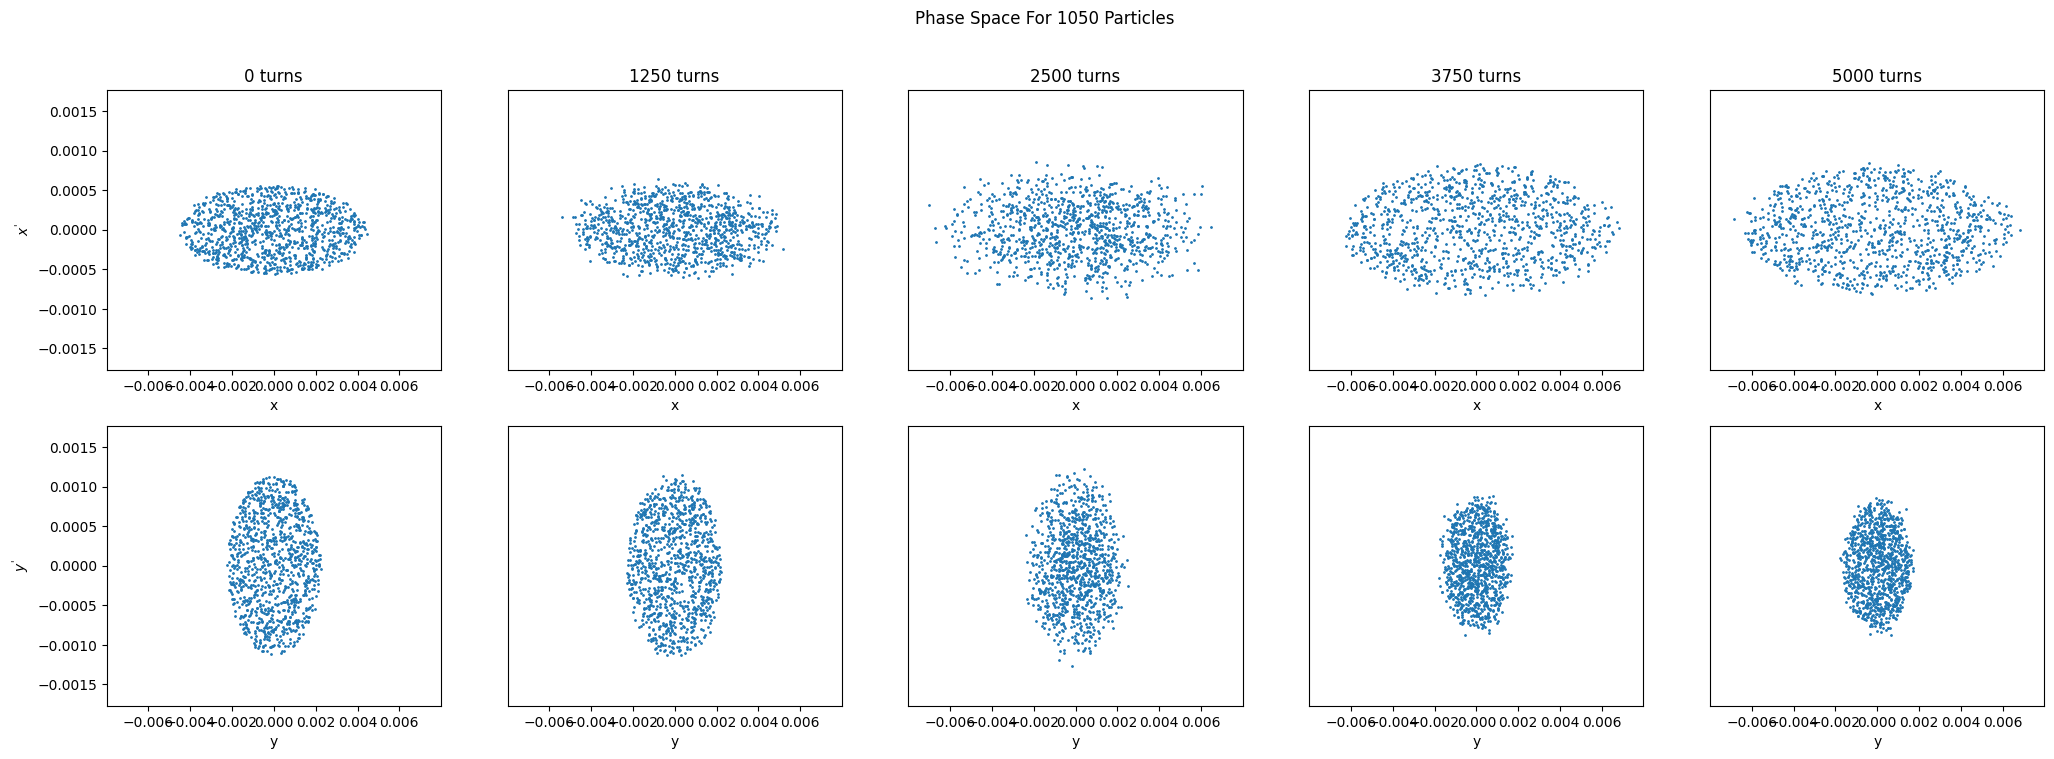

In [100]:
Exchange_multi(X_hist, "Multiparticle Resonance Crossing.png", 5, 1)

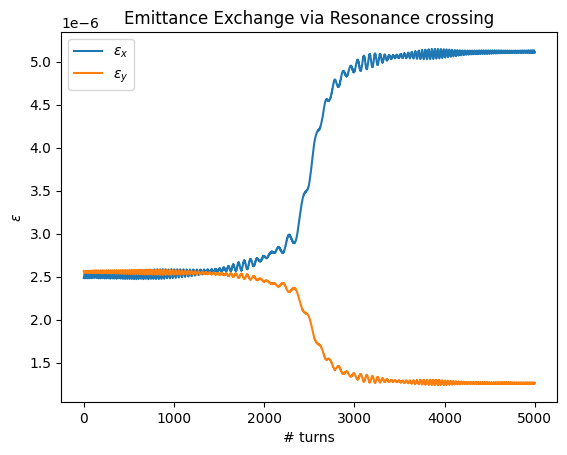

Ratio = 4.051098361574614


In [101]:
plt.plot(Eps_x, label = r"$\epsilon_x$")
plt.plot(Eps_y, label = r"$\epsilon_y$")
plt.xlabel("# turns")
plt.ylabel(r"$\epsilon$")
plt.title("Emittance Exchange via Resonance crossing")
plt.legend()
plt.show()
print("Ratio =", np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):]))

In [102]:
# Vary beta_x
N_turns = 5000
N_iter = 200
ax = 0

Beta_x = np.linspace(1, 20, N_iter)
Ratio_bx = np.zeros(N_iter)
begin = time.time()
for i, bx in enumerate(Beta_x):
    gx = (1 + ax**2)/bx
    Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y
    _, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
    Ratio_bx[i] = np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):])
end = time.time()
print("Time elapsed:", end - begin)

Time elapsed: 432.0427930355072


<IPython.core.display.Math object>

<IPython.core.display.Math object>

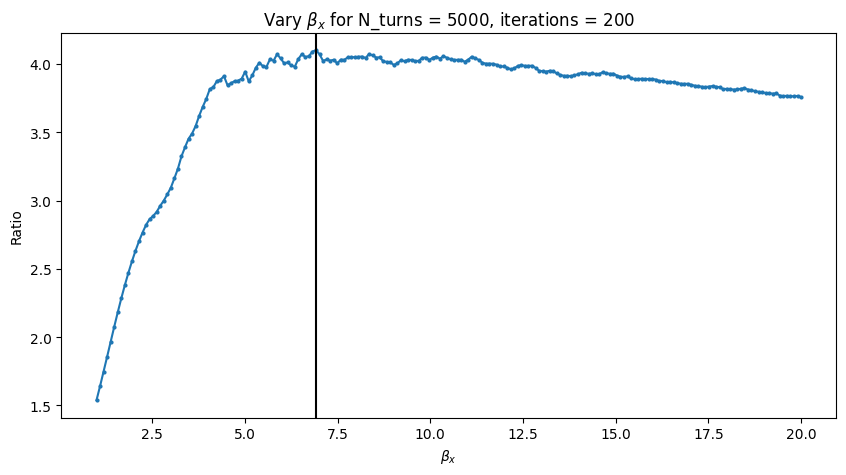

In [103]:
bx_max = Beta_x[np.argmax(Ratio_bx)]
display(Math(r"\beta^{Max Ratio}_x = %f"%bx_max))
display(Math("Max Ratio = %f"%np.max(Ratio_bx)))

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(Beta_x, Ratio_bx, "-o", ms = 2)
plt.xlabel(r"$\beta_x$")
plt.ylabel("Ratio")
plt.title(r"Vary $\beta_x$ for N_turns = %d, iterations = %d"%(N_turns, N_iter))
plt.axvline(x = bx_max, color = "black")
fig.savefig(r"Vary Horizontal Beta for Resonance Crossing")
plt.show()

In [104]:
# Vary beta_y
N_turns = 5000
N_iter = 200
ax = 0
bx = bx_max
gx = (1 + ax**2)/bx

Beta_y = np.linspace(1, 10, N_iter)
Ratio_by = np.zeros(N_iter)
begin = time.time()
for i, by in enumerate(Beta_y):
    gy = (1 + ay**2)/by
    Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y
    _, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
    Ratio_by[i] = np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):])
end = time.time()
print("Time elapsed:", end - begin)

Time elapsed: 488.8032600879669


<IPython.core.display.Math object>

<IPython.core.display.Math object>

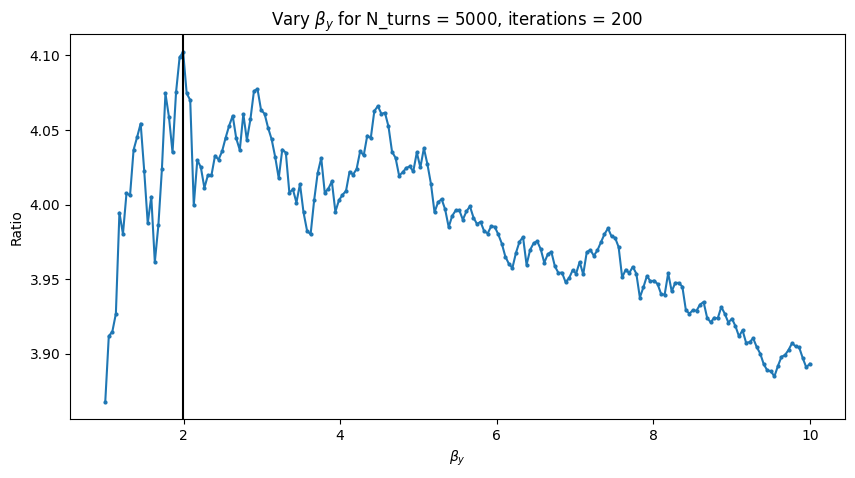

In [105]:
by_max = Beta_y[np.argmax(Ratio_by)]
display(Math(r"\beta^{Max Ratio}_y = %f"%by_max))
display(Math("Max Ratio = %f"%np.max(Ratio_by)))

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(Beta_y, Ratio_by, "-o", ms = 2)
plt.xlabel(r"$\beta_y$")
plt.ylabel("Ratio")
plt.title(r"Vary $\beta_y$ for N_turns = %d, iterations = %d"%(N_turns, N_iter))
plt.axvline(x = by_max, color = "black")
fig.savefig(r"Vary Vertical Beta for Resonance Crossing")
plt.show()

In [108]:
# Vary nu_y
N_turns = 5000
N_iter = 200
ax = 0
bx = bx_max
gx = (1 + ax**2)/bx
by = by_max
gy = (1 + ay**2)/by

Nu_y = np.linspace(nu_xf*2, nu_xi*2, N_iter)
Ratio_nu_y = np.zeros(N_iter)
begin = time.time()
for i, nu_y in enumerate(Nu_y):
    Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y
    _, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
    Ratio_nu_y[i] = np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):])
end = time.time()
print("Time elapsed:", end - begin)

Time elapsed: 513.0234129428864


<IPython.core.display.Math object>

<IPython.core.display.Math object>

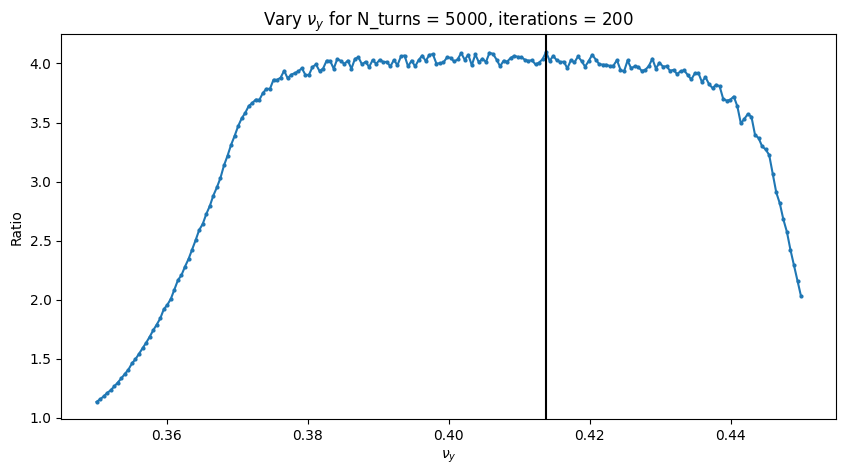

In [109]:
nu_y_max = Nu_y[np.argmax(Ratio_nu_y)]
display(Math(r"\nu^{Max Ratio}_y = %f"%nu_y_max))
display(Math("Max Ratio = %f"%np.max(Ratio_nu_y)))

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(Nu_y, Ratio_nu_y, "-o", ms = 2)
plt.xlabel(r"$\nu_y$")
plt.ylabel("Ratio")
plt.title(r"Vary $\nu_y$ for N_turns = %d, iterations = %d"%(N_turns, N_iter))
plt.axvline(x = nu_y_max, color = "black")
fig.savefig(r"Vary Vertical Tune for Resonance Crossing")
plt.show()

In [111]:
# Vary Sextupole Strength j3
N_turns = 5000
N_iter = 200
ax = 0
bx = bx_max
gx = (1 + ax**2)/bx
by = by_max
gy = (1 + ay**2)/by
nu_y = nu_y_max
Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y

J3 = np.linspace(1, 10, N_iter)
Ratio_j3 = np.zeros(N_iter)
begin = time.time()
for i, j3 in enumerate(J3):
    _, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
    Ratio_j3[i] = np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):])
end = time.time()
print("Time elapsed:", end - begin)

Time elapsed: 496.67635202407837


<IPython.core.display.Math object>

<IPython.core.display.Math object>

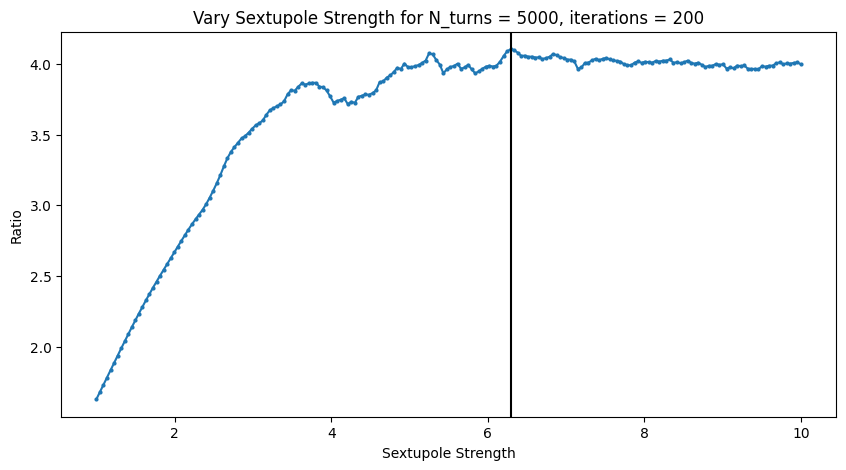

In [112]:
j3_max = J3[np.argmax(Ratio_j3)]
display(Math(r"j^{Max Ratio}_3 = %f"%j3_max))
display(Math("Max Ratio= %f"%np.max(Ratio_j3)))

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(J3, Ratio_j3, "-o", ms = 2)
plt.xlabel("Sextupole Strength")
plt.ylabel("Ratio")
plt.title(r"Vary Sextupole Strength for N_turns = %d, iterations = %d"%(N_turns, N_iter))
plt.axvline(x = j3_max, color = "black")
fig.savefig(r"Vary Sextupole Strength for Resonance Crossing")
plt.show()

In [119]:
# Vary N_turns
N_iter = 200
ax = 0
bx = bx_max
gx = (1 + ax**2)/bx
by = by_max
gy = (1 + ay**2)/by
nu_y = nu_y_max
Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y
j3 = j3_max

N_Turns = np.linspace(1000, 10000, N_iter + 1)
Ratio_turns = np.zeros(N_iter + 1)
begin = time.time()
for i, turns in enumerate(N_Turns):
    turns = int(turns)
    _, Eps_x, Eps_y = Cross2(Twiss, turns, int(N_part/.6), j3)
    Ratio_turns[i] = np.mean(Eps_x[int(turns*.8):])/np.mean(Eps_y[int(turns*.8):])
end = time.time()
print("Time elapsed:", end - begin)

Time elapsed: 489.4287371635437


<IPython.core.display.Math object>

<IPython.core.display.Math object>

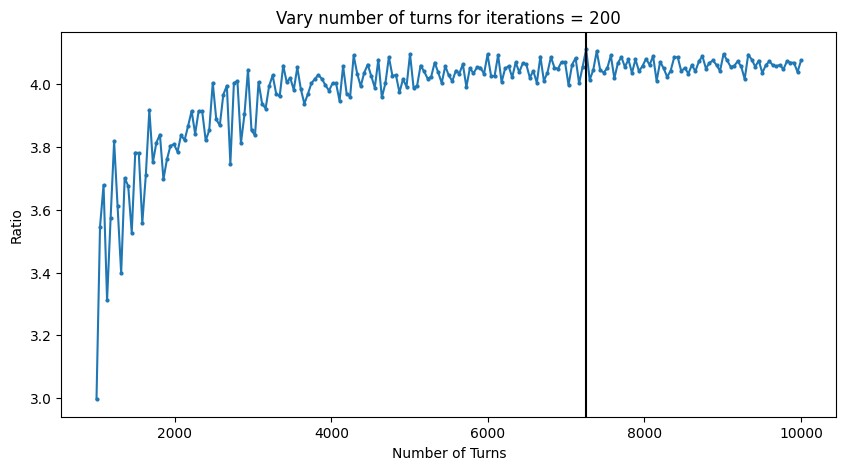

In [121]:
N_turns_max = N_Turns[np.argmax(Ratio_turns)]
display(Math(r"N^{Max Ratio}_{turns} = %f"%N_turns_max))
display(Math("Max Ratio= %f"%np.max(Ratio_turns)))

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(N_Turns, Ratio_turns, "-o", ms = 2)
plt.xlabel('Number of Turns')
plt.ylabel("Ratio")
plt.title(r"Vary number of turns for iterations = %d"%(N_iter))
plt.axvline(x = N_turns_max, color = "black")
fig.savefig(r"Vary number of turns for Resonance Crossing")
plt.show()

In [122]:
# Variables

#Twiss
eps_x = eps_y = 2.5e-6 #m
ax = ay = 0
bx = bx_max #m
by = by_max #m
gx = (1 + ax**2)/bx
gy = (1 + ay**2)/by
nu_xi, nu_xf = .225, .175
nu_y = nu_y_max
Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y

#Magnets
j3L = 4.7
L = .75
j3 = j3_max
display(Math("j_3 = %f"%j3))
G_21L = np.sqrt(2)/(8*np.pi)*bx*np.sqrt(by)*j3L #m^-.5
display(Math("G_{2,-1,l} = %f"%G_21L))

N_turns = 5000
N_part = 1000
delta_dot = (nu_xf - nu_xi)/N_turns

begin = time.time()
print(Twiss, N_turns, int(N_part/.6), j3)
_, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
end = time.time()
print("Time elapsed:", end - begin)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(0, 0, 6.919597989949748, 1.9949748743718594, 0.14451706608569354, 0.5012594458438286, 2.5e-06, 2.5e-06, 0.225, 0.175, 0.41381909547738693) 5000 1666 6.291457286432161
Time elapsed: 1.9492638111114502


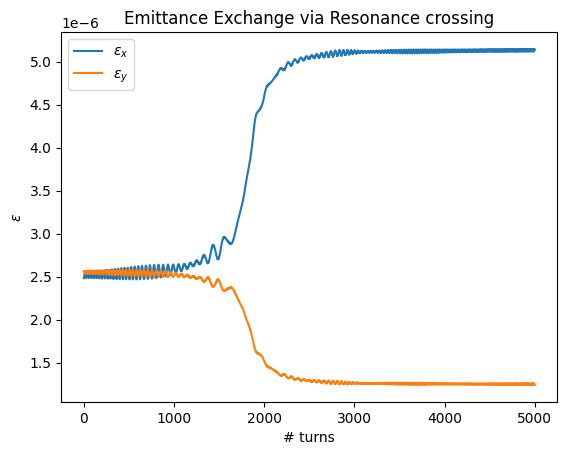

Ratio = 4.104039374084725


In [123]:
plt.plot(Eps_x, label = r"$\epsilon_x$")
plt.plot(Eps_y, label = r"$\epsilon_y$")
plt.xlabel("# turns")
plt.ylabel(r"$\epsilon$")
plt.title("Emittance Exchange via Resonance crossing")
plt.legend()
plt.show()
print("Ratio =", np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):]))

Look at different theory on maximum ratio with this specific resonance
- ask xiaofeng for any paper he may have
- Experiment: use MADx to find 10+1 magnet settings for range(vx_i, vx_f)
   - make sure each magnet setting is a smooth function 
   - See if RHIC has some program that can do this

- GPTune can suggest new sx_i sy_i, so that the modification of each quad is same direction as much as possible.
    - problem: hysteresis when changing current in the opposite direction
    - ask xiaofeng about this as well

In [50]:
#Maximize ratio using Monte Carlo method
ax = ay = 0
bx = 8 #m
by = 2 #m
gx = (1 + ax**2)/bx
gy = (1 + ay**2)/by
nu_xi, nu_xf = .225, .175
nu_y = .4
Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y
j3L = 4.7
L = .75
j3 = j3L/L
N_turns = 1000
Variables = np.array([ax, ay, bx, by, nu_y, j3, N_turns])
Step = np.array([.001, .001, .01, .01, .001, .01, 100])

_, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
ratio_prev = np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):])
#print(ratio_prev)
N_iter = 10
Var_Hist = np.zeros([N_iter, len(Var)])
Ratio = np.zeros(N_iter)
i = 0
while i < N_iter:
    #print(Variables, np.random.normal(size=len(Variables)), Step)
    Variables += np.random.normal(size=len(Variables))*Step
    ax, ay, bx, by, nu_y, j3 = Variables[:-1]
    N_turns = int(Variables[-1])
    #print(Variables, nu_xi, nu_xf)
    if Variables[2] < 0 and Variables[3] < 0: continue
    if Variables[4] < nu_xf*2 or Variables[4] > nu_xi*2: continue
    gx = (1 + ax**2)/bx
    gy = (1 + ay**2)/by
    Twiss = ax, ay, bx, by, gx, gy, eps_x, eps_y, nu_xi, nu_xf, nu_y                                                      
    _, Eps_x, Eps_y = Cross2(Twiss, N_turns, int(N_part/.6), j3)
    ratio_next = np.mean(Eps_x[int(N_turns*.8):])/np.mean(Eps_y[int(N_turns*.8):])
    if ratio_next - ratio_prev > 0: 
        ratio_prev = ratio_next
        Var_Hist[i] = Variables 
        Ratio[i] = ratio_next
        i += 1
    print(i, Variables, N_turns)

print(Var_Hist)
#print(max(Ratio))

1 [-9.02623858e-04  6.69783253e-04  8.01767132e+00  1.99826579e+00
  4.00011310e-01  6.25741204e+00  8.93812598e+02] 893
1 [-1.80524772e-03  1.33956651e-03  8.03534263e+00  1.99653158e+00
  4.00022621e-01  6.24815742e+00  7.87625197e+02] 787
1 [-2.70787157e-03  2.00934976e-03  8.05301395e+00  1.99479737e+00
  4.00033931e-01  6.23890279e+00  6.81437795e+02] 681
1 [-3.61049543e-03  2.67913301e-03  8.07068526e+00  1.99306317e+00
  4.00045241e-01  6.22964817e+00  5.75250394e+02] 575
1 [-4.51311929e-03  3.34891626e-03  8.08835658e+00  1.99132896e+00
  4.00056551e-01  6.22039354e+00  4.69062992e+02] 469
1 [-5.41574315e-03  4.01869952e-03  8.10602789e+00  1.98959475e+00
  4.00067862e-01  6.21113892e+00  3.62875590e+02] 362
1 [-6.31836701e-03  4.68848277e-03  8.12369921e+00  1.98786054e+00
  4.00079172e-01  6.20188429e+00  2.56688189e+02] 256
1 [-7.22099086e-03  5.35826602e-03  8.14137053e+00  1.98612633e+00
  4.00090482e-01  6.19262967e+00  1.50500787e+02] 150
1 [-8.12361472e-03  6.02804928e-

ValueError: Number of samples, -60, must be non-negative.

In [69]:
N_points = 100
J3 = np.linspace(0, 15, N_points + 1)
L = .75
G_21L = np.sqrt(2)/(8*np.pi)*bx*np.sqrt(by)*J3*L #m^-.5
G_eff = G_21L*np.sqrt(eps_x*np.pi/np.abs(delta_dot))
print(G_eff[-1])
    
spread = N_turns//10
FEG = np.zeros(N_points + 1)

begin = time.time()
for i, j in enumerate(J3):
    X_hist, Eps_x, Eps_y = Cross2(Twiss, N_turns, N_part, j)
    eps_x0 = Eps_x[0]
    eps_y0 = Eps_y[0]
    eps_xf = np.mean(Eps_x[N_turns - spread: -1])
    eps_yf = np.mean(Eps_y[N_turns - spread: -1])
    FEG[i] = np.abs((eps_x0 - eps_xf)/eps_x0) + np.abs((eps_y0 - eps_yf)/eps_y0)
end = time.time()
print("Time elapsed:", end - begin)

6.34713281491226
Time elapsed: 211.91766595840454


In [70]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.plot(G_eff, FEG)
ax.set_title("Quality of Emittance Exchange")
ax.set_xlabel(r"$G_{eff}$")
ax.set_ylabel("Fractional Emittance Growth")
#fig.savefig("Quality of Emittance Exchange for Resonance Crossing")
plt.show()

Vary crossing speed

In [57]:
N_points = 100
N_Turns = np.linspace(1000, 8000, N_points + 1)
Delta_dot = (nu_xf - nu_xi)/N_Turns

spread = N_turns//10
FEG = np.zeros(N_points + 1)
begin = time.time()
for i, turns in enumerate(N_Turns):
    _, Eps_x, Eps_y = Cross2(Twiss, int(turns), int(N_part/.6), j3)
    eps_x0 = Eps_x[0]
    eps_y0 = Eps_y[0]
    eps_xf = np.mean(Eps_x[int(turns) - spread: -1])
    eps_yf = np.mean(Eps_y[int(turns) - spread: -1])
    FEG[i] = np.abs((eps_x0 - eps_xf)/eps_x0) + np.abs((eps_y0 - eps_yf)/eps_y0)
end = time.time()
print("Time elapsed:", end - begin)

Time elapsed: 153.2515630722046


In [89]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.plot(N_Turns, FEG)
ax.set_title("Quality of Emittance Exchange vs Crossing Speed")
#ax.set_xlabel(r"$\dot{\delta}$")
ax.set_xlabel(r"turns")
ax.set_ylabel("Fractional Emittance Growth")
fig.savefig("Quality of Emittance Exchange vs N turns")
plt.show()